In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# Some stuff that need to be clarified

## What is it?
Noisy descent - a way that augments gradient descent so that it can escape saddle points. In a more general case, it augments any descent method by adding a noise at each descent step.

Formula:
$$ x^{(k+1)} = x^{(k)} + \alpha^{(k)} g^{(k)} + \epsilon^{(k)} $$

where:
* $\alpha^{(k)}$: the learning rate
* $g^{(k)} = \nabla f(x^{(k)})$: gradient of function $f$ at $k$
* $\epsilon^{(k)}$: the noise, usually a Gaussian noise, i.e. $\epsilon^{(k)} \sim N(0, \sigma)$

## Goal
* To implement noisy descent
* To demonstrate it
* To show its advantages and weeknesses

## Features
* Evaluate the function $f(x)$, where $f: \mathbb{R}^n \rightarrow \mathbb{R}$, $x \in \mathbb{R}^n$ (and $f$ can also work if $x$ is a complex vector too)
* Evaluate $f'(x)$
* Store $k$
* Determine $a^{(k)}$ and $\epsilon^{(k)}$
* Plot coutour map (applied to $x \in \mathbb{R}^2$ only)
* Create GIF

## Approach?
Create a class called `NoisyDescent`, which has a method `optimize` that takes in a function `f`, an initial point `x`, and other arguments (if needed). The function return a vector `x*` that optimizes `f` (for now, just focus on minimizing).

For the sake of plotting and creating GIF, the class can somehow provide the history of iterations. The history includes the number of steps, the value of $x$ used at each step, the value of $f$ at each step.

The arguments that can be applied is:
* the maximum number of iterations
* how big is $h$
* how to evaluate $\alpha^{(k)}$
* the distribution of $\epsilon^{(k)}$

# Report notes

## What to include
* Explain the method
  * What is noisy descent
  * What is the formula
* Advantages
* Disadvantages
* Compare noisy descent to gradient descent
* Extend noisy descent to apply to any descent method

## Implementation
* Explain how to use the class
* Explain what the `optimize()` function do
* Explain the `_sigma()` and `_noise()` functions
* Explain different derivative methods

## Demo
* GIF demo of two functions:
  * $f(x) = x_0^2 - x_1^2$
  * $f(x) = \sin{x_0} + \cos{x_1}$

* Show how noisy descent escapes saddle points
* Show how the variance of the noise reduces after iterations and the gradient becomes more stable
* Show cases where gradient descent defeats noisy descent

## Submission
* Notebook or script?
* GIF animations

## Differentiation method
### Numeric differentiation
$$ f'(x) \approx \frac{f(x + h/2) - f(x - h/2)}{h} $$

### Complex differentiation
When $x \in \mathbb{R}$:
$$ f'(x) \approx \frac{\Im\left(f(x + hi)\right)}{h} $$

When $x \in \mathbb{R}^n$, let

$$ z_j = \begin{bmatrix} x_1 \\ \dots \\ x_j \\ \dots \\ x_n \end{bmatrix} + \begin{bmatrix} 0 \\ \dots  \\ hi \\ \dots \\ 0 \end{bmatrix}$$

then:

$$ \frac{\partial f}{\partial x_j} \approx \frac{\Im(f(z_j))}{h}$$

# Implementation

In [2]:
class NoisyDescent:
    def __init__(self, f, x_dim, initial_point=None, max_iter=1000, alpha=0.1, h=10e-2, diff_method='complex'):
        self.f = f
        self.x_dim = x_dim
        self.initial_point = np.random.randn(x_dim) if initial_point is None else initial_point
        self.max_iter = max_iter
        self.alpha = alpha
        self.h = h
        self.diff_method = diff_method
        
        # Iteration count
        self.k = 0
        
        self.current_x = self.initial_point
        
        # Values of f at each iteration
        self.values = [self.f(self.current_x)]
        
        # Values of x at each iteration
        self.steps = [self.current_x]
        
        self.optimized = False
        self.optimized_x = None
        
    def optimize(self):
        for _ in range(self.max_iter):
            self.k += 1
            
            # Perform noisy descent step
            grad = self._diff()
            self.current_x = self.current_x - self.alpha * grad + self._noise()
            
            # Store values
            f_value = self.f(self.current_x)
            self.values.append(f_value)
            self.steps.append(self.current_x)
        
        self.optimized = True
        self.optimized_x = self.steps[-1]
        return self.optimized_x
    
    def _sigma(self):
        return 1 / self.k
    
    def _noise(self):
        return np.random.normal(scale=self._sigma(), size=(self.x_dim,))
    
    def _diff(self):
        if self.diff_method == 'complex':
            return self._diff_complex()
        elif self.diff_method == 'numeric':
            return self._diff_numeric()
        return 0
    
    def _diff_complex(self):
        H = np.eye(self.x_dim) * complex(0, self.h)
        result = np.apply_along_axis(lambda x: self.f(x).imag / self.h, 1, self.current_x + H)
        return result
    
    def _diff_numeric(self):
        H = np.eye(self.x_dim) * self.h/2
        left = np.apply_along_axis(self.f, 1, self.current_x - H)
        right = np.apply_along_axis(self.f, 1, self.current_x + H)
        return (right - left) / self.h

## Optimizing

Optimizing function:
$$ f(x) = x_0^2 - x_1^2 $$

Initialization: $x = \begin{bmatrix} 1 \\ 0 \end{bmatrix} $

In [6]:
# To reproduce the same result every time
np.random.seed(2)
f = lambda x: x[0]**2 - x[1]**2
nd = NoisyDescent(f, x_dim=2, initial_point=np.array([1, 0]), max_iter=30, alpha=0.04, diff_method='numeric')
nd.optimize()

array([-0.2210216 ,  2.48429218])

## Showing how values of f decrease

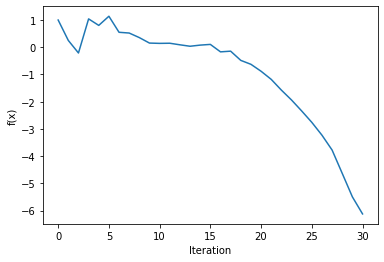

In [4]:
plt.plot(nd.values)
plt.xlabel('Iteration')
plt.ylabel('f(x)')
plt.show()

## Ploting contours

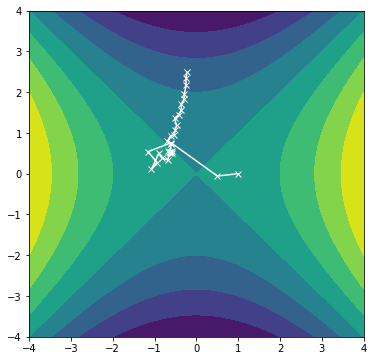

In [5]:
Xs = np.linspace(-4, 4, 100)
Ys = np.linspace(-4, 4, 100)

Xs, Ys = np.meshgrid(Xs, Ys)
Zs = np.apply_along_axis(f, 2, np.stack([Xs, Ys], axis=2))

# Plot countour
plt.figure(figsize=(6, 6))
plt.contourf(Xs, Ys, Zs)

# Plot steps taken
steps = np.array(nd.steps)
plt.plot(steps[:, 0], steps[:, 1], marker='x', color='w');

plt.show()

## Creating GIF

In [12]:
steps = np.array(nd.steps)
frames = []
for i in range(steps.shape[0]):
    # Plot
    plt.contourf(Xs, Ys, Zs)
    plt.plot(steps[:i+1, 0], steps[:i+1, 1], color='white', marker='x')
    
    # Save GIF frame to buffer
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    plt.close()
    buffer.seek(0)
    
    # Load and store frame using PIL
    frame = Image.open(buffer)
    frames.append(frame)

In [13]:
# Save frame
frames[0].save(fp='animations/gradient-descent.gif', format='GIF',
               append_images=frames, save_all=True, duration=100, loop=0)